#### Standard 3D RB Convolutional Autoencoder

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, IterableDataset

import escnn

import numpy as np
import math
import random

import h5py
import os
import sys
sys.path.append('..')

2024-12-22 15:05:02.701908: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 15:05:02.735264: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-22 15:05:03.273993: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import torch
torch.manual_seed(0)

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.cuda.current_device()
    print('Current device:', torch.cuda.get_device_name(DEVICE))
else:
    print('Failed to find GPU. Will use CPU.')
    DEVICE = 'cpu'

Current device: NVIDIA A100 80GB PCIe


## Data

In [3]:
RB_CHANNELS = 4

BATCH_SIZE = 64

SIMULATION_NAME = '48_48_32_2500_0.7_0.01_0.3_300'

HORIZONTAL_SIZE = int(SIMULATION_NAME.split('_')[0])
HEIGHT = int(SIMULATION_NAME.split('_')[2])

In [4]:
sim_file = os.path.join('..', 'data', 'datasets', f'{SIMULATION_NAME}.h5')

with h5py.File(sim_file, 'r') as hf:
    N_train = hf['train'].shape[0]
    N_valid = hf['valid'].shape[0]
    N_test = hf['test'].shape[0]
    standardization_mean = np.array(hf['mean'])
    standardization_std = np.array(hf['std'])

In [5]:
class DataReader(IterableDataset):
    def __init__(self, filename, dataset, num_samples, shuffle=True):
        super().__init__()
        self.filename = filename
        self.dataset = dataset
        self.shuffle = shuffle
        self.num_samples = num_samples

    def generator(self, start=0, end=None):
        if end == None:
            end = self.num_samples
            
        with h5py.File(self.filename, 'r') as hf:
            snapshots = hf[self.dataset]
            
            indices = list(range(start, end))
            if self.shuffle:
                random.shuffle(indices)

            for i in indices:
                snapshot = snapshots[i]
                h, c, w, d = snapshot.shape
                snapshot = snapshot.reshape(h*c, w, d)
                snapshot = torch.Tensor(snapshot).to(DEVICE)
                yield snapshot, snapshot
                
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = 0
            iter_end = self.num_samples
        else:  # in a worker process
            # split workload
            per_worker = int(math.ceil((self.num_samples) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = worker_id * per_worker
            iter_end = min(iter_start + per_worker, self.num_samples)
        return self.generator(iter_start, iter_end)


train_dataset = DataReader(sim_file, 'train', num_samples=N_train, shuffle=True)
valid_dataset = DataReader(sim_file, 'valid', num_samples=N_valid, shuffle=True)
test_dataset = DataReader(sim_file, 'test', num_samples=N_test, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False, drop_last=False)

print('training samples', N_train)
print('validation samples', N_valid)
print('testing samples', N_test)

training samples 24030
validation samples 8010
testing samples 8010


In [6]:
from escnn import nn as enn
from escnn import gspaces
from escnn.gspaces import GSpace
from torch import Tensor

class DataAugmentation:
    def __init__(self, in_height: int, gspace: GSpace = gspaces.flipRot2dOnR2(N=8)):
        self.gspace = gspace
        da_irrep_frequencies = (1, 1) if gspace.flips_order > 0 else (1,) # depending whether using Cn or Dn group  
        self.data_aug_type = enn.FieldType(gspace, 
                                        in_height*[gspace.trivial_repr, 
                                                   gspace.irrep(*da_irrep_frequencies), 
                                                   gspace.trivial_repr])
        
    def __call__(self, *inputs: list[Tensor]) -> Tensor:
        if len(inputs) == 0: return None
        
        transformation = self.gspace.fibergroup.sample()
        
        transformed_inputs = []
        for input in inputs:
            input = enn.GeometricTensor(input, self.data_aug_type)
            transformed_input = input.transform(transformation)
            transformed_inputs.append(transformed_input.tensor)
            
        return transformed_inputs[0] if len(inputs) == 1 else transformed_inputs

## Model Definition

In [ ]:
from models.steerable_cnn_model import RBSteerableAutoEncoder
from models.cnn_model import RBAutoEncoder
from models.cnn3d_model import RB3DAutoEncoder

h_kernel_size, v_kernel_size = 3, 5

# TODO experiment whether 1x1 kernel for latent and out conv are helpfull

model = RBSteerableAutoEncoder(gspace=escnn.gspaces.flipRot2dOnR2(N=4), # or rot2dOnR2, flipRot2DOnR2
                               rb_dims=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT),
                               encoder_channels=(16, 32, 48, 96),
                               latent_channels=32//8, # 32 // |G|
                               v_kernel_size=v_kernel_size, h_kernel_size=h_kernel_size) 

# model = RBAutoEncoder(rb_dims=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT),
#                       encoder_channels=(16, 32, 72, 145),
#                       latent_channels=32,
#                       v_kernel_size=v_kernel_size, h_kernel_size=h_kernel_size)

# model = RB3DAutoEncoder(rb_dims=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT),
#                         encoder_channels=(40, 81, 162, 325),
#                         latent_channels=32,
#                         v_kernel_size=v_kernel_size, h_kernel_size=h_kernel_size)

model.to(DEVICE)

model.summary()

+--------------+--------------------------------+------------+
| Layer        | Output shape [c, |G|, w, d, h] | Parameters |
+--------------+--------------------------------+------------+
| Input        |             [4, 1, 48, 48, 32] |          0 |
| EncoderConv1 |            [16, 8, 48, 48, 32] |     37,888 |
| Pooling1     |            [16, 8, 24, 24, 16] |          0 |
| EncoderConv2 |            [32, 8, 24, 24, 16] |  1,180,672 |
| Pooling2     |             [32, 8, 12, 12, 8] |          0 |
| EncoderConv3 |             [48, 8, 12, 12, 8] |  1,770,240 |
| Pooling3     |               [48, 8, 6, 6, 4] |          0 |
| EncoderConv4 |               [96, 8, 6, 6, 4] |  2,654,976 |
| Pooling4     |               [96, 8, 3, 3, 2] |          0 |
| LatentConv   |                [4, 8, 3, 3, 2] |    110,608 |
| DecoderConv1 |               [96, 8, 3, 3, 2] |    110,976 |
| Upsampling1  |               [96, 8, 6, 6, 4] |          0 |
| DecoderConv2 |               [48, 8, 6, 6, 4] |  2,65

## Training

In [8]:
# loss_fn = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
# data_augmentation = DataAugmentation(in_height=model.in_dims[-1], gspace=gspaces.flipRot2dOnR2(N=4))

In [9]:
# def train_one_epoch(train_loss_freq=20):
#     running_loss = 0.
#     last_loss = 0.

#     for i, (inputs, _) in enumerate(train_loader):
#         # Zero your gradients for every batch!
#         optimizer.zero_grad()

#         # Make predictions for this batch
#         inputs = data_augmentation(inputs)
#         predictions = model(inputs)

#         # Compute the loss and its gradients
#         loss = loss_fn(predictions, inputs)
#         loss.backward()

#         # Adjust learning weights
#         optimizer.step()

#         # Gather data and report
#         running_loss += loss.item()
#         if i % train_loss_freq == train_loss_freq-1:
#             last_loss = running_loss / train_loss_freq # loss per batch
#             print('  batch {} loss: {}'.format(i + 1, last_loss))
#             running_loss = 0.
            
#     if i+1 < train_loss_freq:
#         last_loss = running_loss / i+1 # loss per batch

#     return last_loss

In [10]:
# from datetime import datetime

# # Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# epoch_number = 0

# EPOCHS = 100

# best_vloss = 1_000_000.

# for epoch in range(EPOCHS):
#     print('EPOCH {}:'.format(epoch_number + 1))

#     # Make sure gradient tracking is on, and do a pass over the data
#     model.train(True)
#     avg_loss = train_one_epoch()


#     running_vloss = 0.0
#     # Set the model to evaluation mode, disabling dropout and using population
#     # statistics for batch normalization.
#     model.eval()

#     # Disable gradient computation and reduce memory consumption.
#     with torch.no_grad():
#         for i, vdata in enumerate(valid_loader):
#             vinputs, vlabels = vdata
#             voutputs = model(vinputs)
#             vloss = loss_fn(voutputs, vlabels)
#             running_vloss += vloss

#     avg_vloss = running_vloss / (i + 1)
#     print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

#     # Track best performance, and save the model's state
#     if avg_vloss < best_vloss:
#         best_vloss = avg_vloss
#         model_path = 'model_{}_{}'.format(timestamp, epoch_number)
#         # torch.save(model.state_dict(), model_path)

#     epoch_number += 1
    
    
# # TODO Setup von Alexander Schnelle nehmen
# # TODO LR Schedule
# # TODO Early stopping

In [9]:
from tqdm.notebook import tqdm
model_dir = './trained_models'

# Model
model_name = "D4"
start_epoch = 0 # Will load existing model if start_epoch is greater than 0.

# Training parameters
learning_rate = 1e-3
epochs = 100
batch_size = 64
earlystops = [20]

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
data_augmentation = DataAugmentation(in_height=model.in_dims[-1], gspace=gspaces.flipRot2dOnR2(N=4))

# Load model
if start_epoch > 0:
    file_name = f"{model_name}_bs{batch_size}_e{start_epoch}.tar"
    file_path = os.path.join(model_dir, file_name)
    assert os.path.exists(file_path), f"Did not find a saved model with the name '{file_name}'."
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    early_stop_count = checkpoint['early_stop_count']
    model.eval()
    print(f"Loaded state at epoch {start_epoch} with an early stop count of {early_stop_count}.")

# Scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.1, last_epoch=start_epoch-1)
enableScheduler = True

#######


def train_loop(dataloader, model, loss_fn, optimizer, epochnum):
    model.train() # Sets the model to training mode -- important for batch normalization and dropout layers
    train_loss = 0.0
    for i, (x, _) in tqdm(enumerate(dataloader, 1), 
                          total=math.ceil(N_train/BATCH_SIZE), 
                          desc=f'epoch {epochnum}'):
        # Compute prediction and loss
        x = data_augmentation(x)
        pred = model(x)
        loss = loss_fn(pred, x)
        train_loss += loss.item() * len(x)
    
        # Backpropagation
        optimizer.zero_grad() # Resets gradient
        loss.backward() # Backpropagates the prediction loss
        optimizer.step() # Adjusts the parameters by the gradients collected in the backward pass
    return train_loss / i

def valid_loop(dataloader, model, loss_fn):
    model.eval() # Sets the model to evaluation mode -- important for batch normalization and dropout layers
    valid_loss = 0.0
    with torch.no_grad(): # Ensures that no gradients are computed during test mode
        for i, (x, y) in enumerate(dataloader, 1):
            pred = model(x)
            valid_loss += loss_fn(pred, y).item() * len(x)
    return valid_loss / i

def save_checkpoint(path, weights, optimizer_state, early_stop_count):
    torch.save({
        'model_state_dict': weights,
        'optimizer_state_dict': optimizer_state,
        'early_stop_count': early_stop_count
    }, path)

#####

from copy import deepcopy
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(f"runs/{model_name}_bs{batch_size}")

output_file = os.path.join(model_dir, model_name)

best_loss = np.inf
best_epoch = -1
train_loss_values = list()
valid_loss_values = list()
patience = earlystops.pop(0)
for epoch in tqdm(range(start_epoch, start_epoch+epochs), desc='training'):
    train_loss = train_loop(train_loader, model, loss_fn, optimizer, epoch)
    valid_loss = valid_loop(valid_loader, model, loss_fn)
    print(f'{train_loss=:.4f}   -   {valid_loss=:.4f}')
    if enableScheduler:
        scheduler.step()
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/valid', valid_loss, epoch)
    train_loss_values.append(train_loss)
    valid_loss_values.append(valid_loss)
    if valid_loss < best_loss:
        early_stop_count = 0
        best_loss = valid_loss
        best_epoch = epoch+1
        best_weights = deepcopy(model.state_dict())
        best_optim = optimizer.state_dict()
    else:
        early_stop_count += 1
    if early_stop_count >= patience:
        print(f"Ran out of patience at epoch {epoch}. Best epoch is {best_epoch} with a loss of {best_loss}.")
        save_checkpoint(f"{output_file}_bs{batch_size}_e{best_epoch}.tar", best_weights, best_optim, early_stop_count)
        torch.save(best_weights, f"{output_file}_bs{batch_size}.pt")
        if earlystops:
            patience = earlystops.pop(0)
            print(f"Saving the model and resuming with a patience of {patience}.")
        else:
            print(f"No more patience left.")
            break
        
writer.flush()
writer.close()
if epoch == start_epoch+epochs-1:
    last_weights = deepcopy(model.state_dict())
    last_optim = optimizer.state_dict()
    save_checkpoint(f"{output_file}_bs{batch_size}_e{start_epoch+epochs}.tar", last_weights, last_optim, early_stop_count)
    print(f"Reached the last epoch without losing patience. early_stop_count={early_stop_count}")
plt.plot(train_loss_values, label="train")
plt.plot(valid_loss_values, label="valid")
plt.title(f"Learning rate: {learning_rate:>.1e}   Best loss: {best_loss:>.3f}   Best epoch: {best_epoch}")
plt.legend()
plt.show()

training:   0%|          | 0/100 [00:00<?, ?it/s]

epoch 0:   0%|          | 0/376 [00:00<?, ?it/s]

train_loss=15.4323   -   valid_loss=6.5271


epoch 1:   0%|          | 0/376 [00:00<?, ?it/s]

train_loss=5.3491   -   valid_loss=3.6451


epoch 2:   0%|          | 0/376 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Evaluation

### Equivariance

In [12]:
model.check_equivariance(gpu_device=DEVICE, atol=1e-3)

(+, 0[2pi/4]) 0.0 0.0 0.0
(+, 1[2pi/4]) 0.00026714802 2.4926027e-05 4.3974668e-10
(+, 2[2pi/4]) 0.00025105476 2.486219e-05 4.3453305e-10
(+, 3[2pi/4]) 0.00031006336 2.423603e-05 4.0237447e-10
(-, 0[2pi/4]) 0.0002937317 2.4581535e-05 4.2685466e-10
(-, 1[2pi/4]) 0.00027179718 2.352911e-05 3.9555706e-10
(-, 2[2pi/4]) 0.000302732 2.4790425e-05 4.2911122e-10
(-, 3[2pi/4]) 0.00021660328 2.412023e-05 3.9452674e-10


[((+, 0[2pi/4]), 0.0),
 ((+, 1[2pi/4]), 2.4926027e-05),
 ((+, 2[2pi/4]), 2.486219e-05),
 ((+, 3[2pi/4]), 2.423603e-05),
 ((-, 0[2pi/4]), 2.4581535e-05),
 ((-, 1[2pi/4]), 2.352911e-05),
 ((-, 2[2pi/4]), 2.4790425e-05),
 ((-, 3[2pi/4]), 2.412023e-05)]

### MSE

In [13]:
model.eval()

running_test_loss = 0
with torch.no_grad():
    for i, (inputs, outputs) in enumerate(test_loader):
        predictions = model(inputs)
        test_loss = loss_fn(outputs, predictions)
        running_test_loss += test_loss
        
avg_test_loss = running_test_loss / (i + 1)

print(float(avg_test_loss))

0.016146814450621605


### Snapshots

In [14]:
model.eval()

snapshots = next(iter(test_loader))[0][:20]
decoded = model(snapshots)

snapshots = snapshots.cpu().detach().numpy()
decoded = decoded.cpu().detach().numpy()

snapshots = snapshots.reshape(20, HEIGHT, RB_CHANNELS, HORIZONTAL_SIZE, HORIZONTAL_SIZE)
decoded = decoded.reshape(20, HEIGHT, RB_CHANNELS, HORIZONTAL_SIZE, HORIZONTAL_SIZE)

snapshots = snapshots*standardization_std+standardization_mean
decoded = decoded*standardization_std+standardization_mean

snapshots = snapshots.transpose(0, 3, 4, 1, 2) # -> n, w, d, h, c
decoded = decoded.transpose(0, 3, 4, 1, 2) # -> n, w, d, h, c

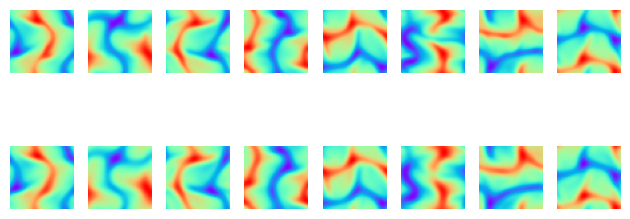

In [15]:
from matplotlib import pyplot as plt

for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.imshow(snapshots[i, :, :, 16, 0], cmap='rainbow')
    plt.axis('off')
    plt.tight_layout()

    plt.subplot(2, 8, 8+i+1)
    plt.imshow(decoded[i, :, :, 16, 0], cmap='rainbow')
    plt.axis('off')
    plt.tight_layout()
plt.show()

### Animation

In [16]:
# use raw simulation data for animation since train/valid/test datasets are shuffled
def get_sim_data():
    sim_file = h5py.File(os.path.join('..', 'data', 'datasets', f'{SIMULATION_NAME}.h5'), 'r')
    return sim_file, sim_file['test']


def predict_batch(sim_data, i, size):
    """Calculates the models output of a batch of raw simulation data."""
    # prepare input
    inputs = sim_data[i*size:(i+1)*size, :, :, :, :]
    
    b, h, c, w, d = inputs.shape
    inputs = inputs.reshape(b, h*c, w, d)
    inputs = torch.Tensor(inputs).to(DEVICE)
    
    # predict
    model.eval()
    pred = model(inputs)
    
    inputs = inputs.cpu().detach().numpy()
    pred = pred.cpu().detach().numpy()
    
    inputs = inputs.reshape(b, h, c, w, d)
    pred = pred.reshape(b, h, c, w, d)
    
    # remove standardization
    inputs = inputs*standardization_std + standardization_mean
    pred = pred*standardization_std + standardization_mean
    
    inputs = inputs.transpose(0, 3, 4, 1, 2) # -> n, w, d, h, c
    pred = pred.transpose(0, 3, 4, 1, 2) # -> n, w, d, h, c
    
    return inputs, pred

In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def auto_encoder_animation(axis, animation_name, slice, fps, batch_size=32):
    """Animates the output of a AE next to the input across a 2D slice.

    Args:
        axis: 0, 1, 2 for slices across the width, depth or height axis respectively
    """
    sim_file, sim_data = get_sim_data()
    
    batch_x, batch_y = predict_batch(sim_data, 0, batch_size)
    current_batch_nr = 0

    # prepare plot
    if axis == 2:
        # is square when looking from above
        img_extent = [0, 2*np.pi, 0, 2*np.pi]
    else:
        img_extent = [0, 2*np.pi, 0, 2]
    fig = plt.figure()
    ax = plt.subplot(1,2,1)
    orig_im = plt.imshow(np.rot90(batch_x[0, :, :, :, 0].take(indices=slice, axis=axis)), cmap='rainbow', extent=img_extent)
    plt.axis('off')
    ax.set_title('input')

    ax = plt.subplot(1,2,2)
    pred_im = plt.imshow(np.rot90(batch_y[0, :, :, :, 0].take(indices=slice, axis=axis)), cmap='rainbow', extent=img_extent)
    plt.axis('off')
    ax.set_title('output')
    
    def frame_updater(frame):
        """Computes the next frame of the animation."""
        nonlocal batch_x, batch_y, current_batch_nr
        
        required_batch_nr, in_batch_frame = frame//batch_size, frame%batch_size
        if required_batch_nr > current_batch_nr:
            # required to predict next batch
            current_batch_nr = required_batch_nr
            batch_x, batch_y = predict_batch(sim_data, required_batch_nr, batch_size)
        
        # update frames
        orig_data = np.rot90(batch_x[in_batch_frame, :, :, :, 0].take(indices=slice, axis=axis))
        pred_data = np.rot90(batch_y[in_batch_frame, :, :, :, 0].take(indices=slice, axis=axis))
        orig_im.set_array(orig_data)
        pred_im.set_array(pred_data)
        
        # update color map limits
        vmin = min(np.min(orig_data), np.min(pred_data))
        vmax = max(np.max(orig_data), np.max(pred_data))
        orig_im.set_clim(vmin=vmin, vmax=vmax)
        pred_im.set_clim(vmin=vmin, vmax=vmax)
        
        return orig_im, pred_im
    
    anim = animation.FuncAnimation(fig, frame_updater, frames=sim_data.shape[0], interval=1000/fps, blit=True)
    anim.save(f'{animation_name}.mp4')
    
    sim_file.close()

**Width slice**

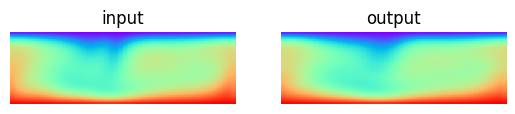

In [18]:
auto_encoder_animation(axis=0, animation_name='animations/width', slice=24, fps=30)

from IPython.display import Video
Video("animations/width.mp4")

**Depth slice**

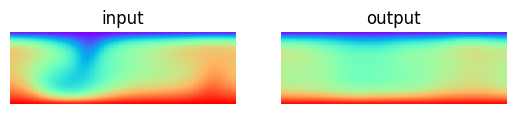

In [ ]:
auto_encoder_animation(axis=1, animation_name='animations/depth', slice=24, fps=30)

from IPython.display import Video
Video("animations/depth.mp4")

**Height slice**

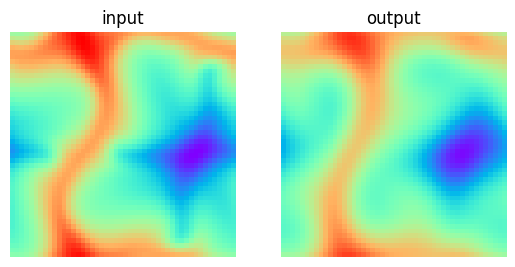

In [18]:
auto_encoder_animation(axis=2, animation_name='animations/height', slice=16, fps=30)

from IPython.display import Video
Video("animations/height.mp4")